# Imports


In [1]:
from pathlib import Path

from IPython.core.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_connectivity
from tqdm.notebook import tqdm
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

import acareeg
from infant_connectivity import load_connectivity_data, get_demo_data, label_outliers, logit

# Global variables and configuration

In [2]:
palette = sns.color_palette(["green", "orange", "red"])

#con_path = Path("/Volumes/usc_data/ElementSE/eegip/con_paper/")
con_path = Path("/Users/christian/Documents/con_paper/")

plt.rcParams['figure.facecolor'] = 'white'

# Loading data

In [3]:
demo_data = get_demo_data(force_download=False)

### Adding group information

In [12]:
bands = ("theta", "alpha", "beta", "gamma", "broadband")

tmp3 = []
for band in tqdm(bands):
    con_data = load_connectivity_data(con_path, band=band, con_name="ciplv", lambda2=1e-4)

    dat = con_data.merge(demo_data, on=["subject_no", "dataset"])

    site_mapping = {"washington": "Seattle", "london": "London"}
    dat["dataset"] = [site_mapping[dataset] for dataset in dat.dataset]
    dat.rename(columns={"dataset": "site"}, inplace=True)
    dat = dat[dat.age != 18]

    label_outliers(dat)

    tmp = dat.copy()
    tmp["log_con"] = logit(tmp.con)
    tmp = tmp[~tmp.outliers_logit]

    tmp2 = tmp.copy()
    tmp2["site"] = "Combined"
    tmp = pd.concat([tmp, tmp2])

    tmp2 = tmp.copy()
    tmp2["sex"] = "M & F"
    tmp = pd.concat([tmp, tmp2])

    tmp3.append(tmp.groupby(["age", "subject", "sex", "site", "group", "band"], observed=True).mean()[["log_con"]].reset_index())

tmp3 = pd.concat(tmp3)

  0%|          | 0/5 [00:00<?, ?it/s]

0 files missing from ANTS12-0Months3T.txt in /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T
    3 BEM surfaces found
    Reading a surface...
[done]
    Reading a surface...
[done]
    Reading a surface...
[done]
    3 BEM surfaces read
Loading surfaces...

Loading the solution matrix...

Three-layer model surfaces loaded.
Loaded linear collocation BEM solution from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/bem/ANTS12-0Months3T-5120-5120-5120-bem-sol.fif
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
Reading labels from parcellation...
   read 34 labels from /Users/christian/Code/papers/asd_infants_eeg_con_paper/ANTS12-0Months3T/label/lh.aparc.annot
   read 34 labels from /Users

/Users/christian/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_4837/3756370820.py:52: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout(h_pad=4, w_pad=1)
/Users/christian/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_4837/3756370820.py:52: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout(h_pad=4, w_pad=1)
/Users/christian/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/3k/220tdhsn33709gq9ylr8c6kh0000gp/T/ipykernel_4837/3756370820.py:52: UserWarning: The figure layou

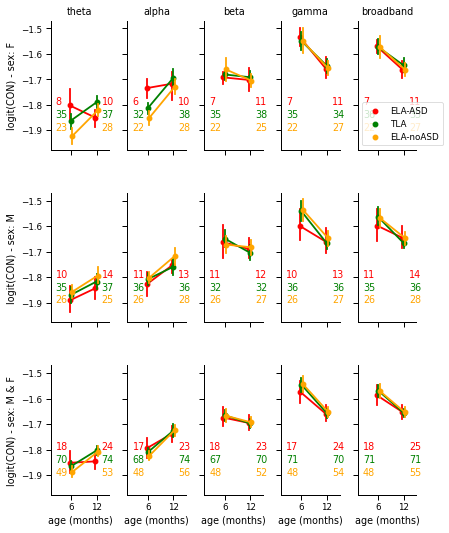

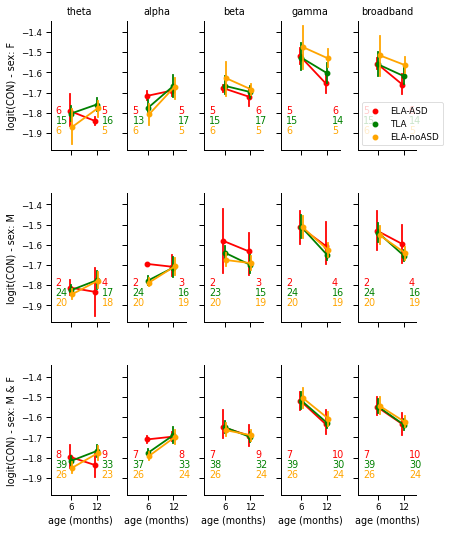

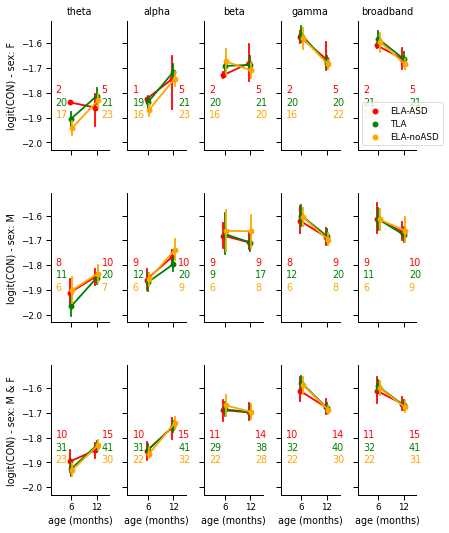

In [31]:
palette = sns.color_palette(["red", "green", "orange"])

plot_kwds = {"x": "age", "hue": "group",
             "dodge":0.1, "palette":palette, 
             "hue_order":["ELA-ASD", "TLA", "ELA-noASD"],
             "join": True}

paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)  

tmp3.group = tmp3.group.astype(str)
tmp3.group = tmp3.group.str.replace("Control", "TLA").str.replace("HRA", "ELA")

col_order = tmp3.band.unique()
row_order = ["F", "M", "M & F"]

for site in tmp3.site.unique():
    g = sns.catplot(data=tmp3[tmp3.site == site], row="sex", 
                    col="band", kind="point", y="log_con", 
                    col_order=col_order, row_order=row_order, legend_out=False, 
                    height=2.5, aspect=0.5, **plot_kwds)

    for ax, sex in zip(g.axes.T[0], row_order):
        ax.set_ylabel(f"logit(CON) - sex: {sex}")
        
    for ax in g.axes[-1]:
        ax.set_xlabel("age (months)")
    for ax in g.axes[0]:
        ax.set_xlabel("")

    g.axes[0, 0].legend().set_visible(False)
    legend = g.axes[0, -1].legend()

    group_order = [text.get_text() for text in legend.texts]
    color_order = [line.get_color() for line in ax.lines[::3]]

    for ax in g.axes.ravel(): 
        ax.set_title("") 
        ax.set_xlim(-0.8, 1.5)

    counts = tmp3[tmp3.site == site].groupby(["sex", "band", "group", "age"]).count()["subject"]
    for sex, ax_row in zip(row_order, g.axes): 
        for band, ax in zip(col_order, ax_row):
            for group, color, y in zip(group_order, color_order, [-1.8, -1.85, -1.9]):
                for age, x in zip([6, 12], [-0.6, 1.2]):
                    ax.text(x, y, f"{counts[sex, band, group, age]}",
                            color=color)

    for band, ax in zip(col_order, g.axes[0]):
        ax.set_title(band) 

    g.fig.tight_layout(h_pad=4, w_pad=1)

    g.fig.savefig(f"images/band_example_all_relationships_{site}.png", dpi=300)